# Прогон на случайных 10 образцах из HGDP

Запуск подсчёта FFT_dF и DTCWT_Entropy:

```bash
cd ~/data/HGDP/las
samples=$(find /mnt/projects/spector/SWaveform/HGDP/cram/ -type d | shuf -n 10)
for s in $samples; do
  s_name=$(basename ${s})
  MEAN=$(cat $s.mosdepth.summary.txt | grep "total" | awk '{print $4}')
  echo -e "Genome: "$s_name" – Mean coverage: "${MEAN}" [$(date)]";
  for chr in $(ls -v1 $s/*.bcov); do 
    chr_name=$(basename ${chr})
    chr_name=$(echo ${chr_name/\.bcov/});
    python3 ~/CLas/tools/pylas.py ${chr} 14 $MEAN ${chr_name} > ${chr_name}".tmp" &
  done
  wait;
  echo "#chr start end FFT_dF DTCWT_Entropy Std" > ${s_name}"_p14.las";
  for tmp in $(ls -v1 *.tmp); do 
    cat ${tmp} >> ${s_name}"_p14.las";
    rm -f ${tmp};
  done
  echo -e "Done: "${s_name}"_p14.las\n";
done
```

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, glob, os
    
def load_f(src, name):
    dt = pd.read_csv(f'{src}', sep=' ')
    dt['Name'] = name
    return dt

LB = pd.concat([load_f(f'../../data/GIAB/_las_noappr/HG00{i}_p14.lasbed', f'HG00{i}') for i in [1,2,3,4,5,6,7]])
LB = LB[LB['covered_bases'] > 0]

In [2]:
gbd = glob.glob('../../data/HGDP/las/*.las')
GB = pd.concat([load_f(src, os.path.basename(src)) for src in gbd])

In [13]:
def separate(T):
    V = [{
      'good': T.loc[(T['covered_bases'] == 1) & (T['acent'] == 0)],
      'bad':  T.loc[(T['covered_bases'] < 1) | (T['acent'] > 0)]
    }]
    V.append({
      'good': V[0]['good'][V[0]['good']['all_diff'] <= 0.8],
      'bad':  V[0]['good'][V[0]['good']['all_diff'] > 0.8]
    })
    V.append({
      'good': V[1]['good'][V[1]['good']['lc_vcf'] == 0],
      'bad':  V[1]['good'][V[1]['good']['lc_vcf'] > 0]
    })
    V.append({
      'good': V[2]['good'][V[2]['good']['hc_vcf'] <= 0.1],
      'bad':  V[2]['good'][V[2]['good']['hc_vcf'] > 0.1]
    })
    return V

In [4]:
with open('_matrix.v1.json', 'r') as f:
    mat, xar, yar = [np.array(e) for e in json.load(f)]

# Globals: mat, xar, yar
def m_index(obj, v):
    if obj[0] > v or obj[-1] < v: return -1
    return np.where(obj <= v)[0][-1]

def byMatrix(x, y):
    i, j = (m_index(xar, x), m_index(yar, y))
    if i < 0 or j < 0: return -1
    return mat[i][j]

# [(LB['FFT_dF'] - fft_m)/fft_s, -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s]

In [18]:
threshold = 0.6262906682133951
fft_m, fft_s = (1928.1957682, 216.2054816965535)
dtt_m, dtt_s = (9.1154286, 0.01960891258940661)

nor7d = [(GB['FFT_dF'] - fft_m)/fft_s, -(GB['DTCWT_Entropy'] - dtt_m)/dtt_s]
GB['matrix'] = [byMatrix(x_, y_) for x_, y_ in np.transpose(nor7d)]

GB['FFT_dF_n'] = (GB['FFT_dF'] - fft_m)/fft_s
GB['DTCWT_Entropy_n'] = -(GB['DTCWT_Entropy'] - dtt_m)/dtt_s

LB['FFT_dF_n'] = (LB['FFT_dF'] - fft_m)/fft_s
LB['DTCWT_Entropy_n'] = -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s
SLB = separate(LB)

In [9]:
# GB['matrix'] > threshold

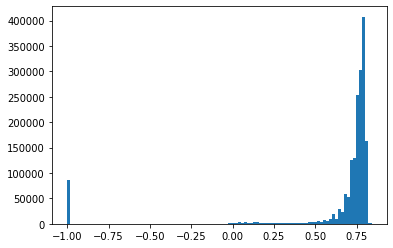

In [7]:
plt.hist(GB['matrix'], bins=100)
plt.show()

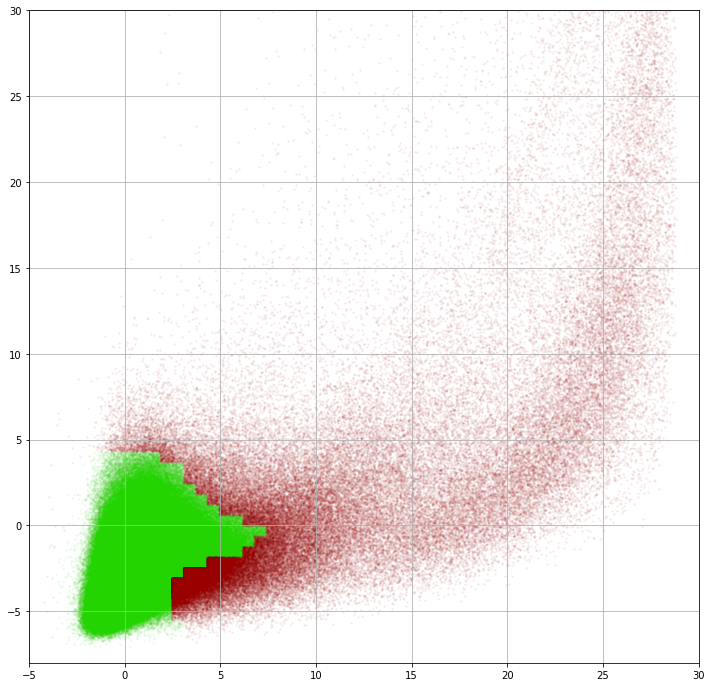

In [8]:
colors = ['#900', '#d4cf00', '#d49c00', '#004ad4', '#24d400']
plt.figure(figsize=(12, 12))
plt.grid()
xs, ys = ('FFT_dF_n', 'DTCWT_Entropy_n')
G_, B_ = (GB[GB['matrix'] > threshold], GB[GB['matrix'] <= threshold]) 
plt.scatter(G_[xs], G_[ys], alpha=0.05, s=2.5, color=colors[-1])
plt.scatter(B_[xs], B_[ys], alpha=0.05, s=2.5, color=colors[0])
plt.xlim(-5, 30)
plt.ylim(-8, 30)
plt.show()

In [22]:
def viz(Sn, xs, ys):
    colors = ['#900', '#d4cf00', '#d49c00', '#004ad4', '#24d400']
    plt.figure(figsize=(12, 12))
    plt.grid()
    for i in range(4):
        plt.scatter(Sn[i]['bad'][xs], Sn[i]['bad'][ys], alpha=0.05, s=2.5, color=colors[i])
    plt.scatter(Sn[3]['good'][xs], Sn[3]['good'][ys], alpha=0.05, s=2.5, color=colors[-1])
    return plt

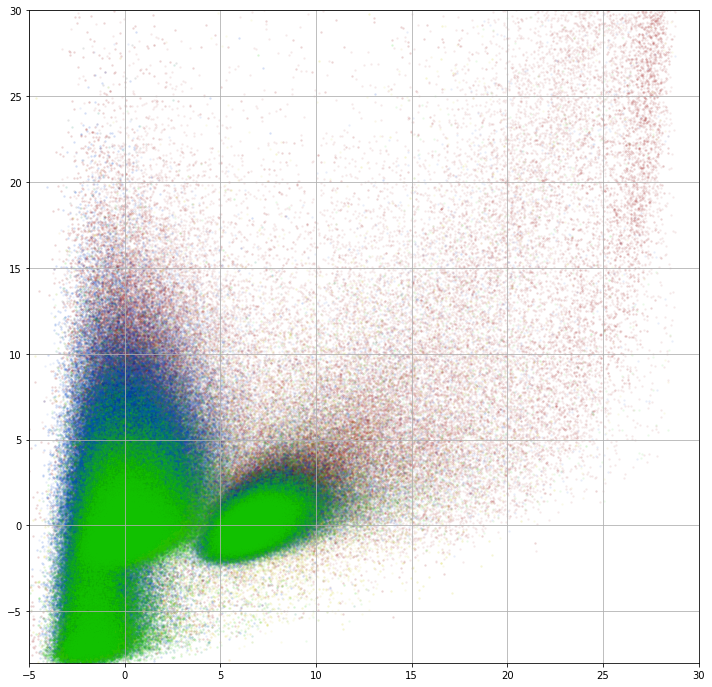

In [23]:
p = viz(SLB, 'FFT_dF_n', 'DTCWT_Entropy_n')
p.xlim(-5, 30)
p.ylim(-8, 30)
plt.show()

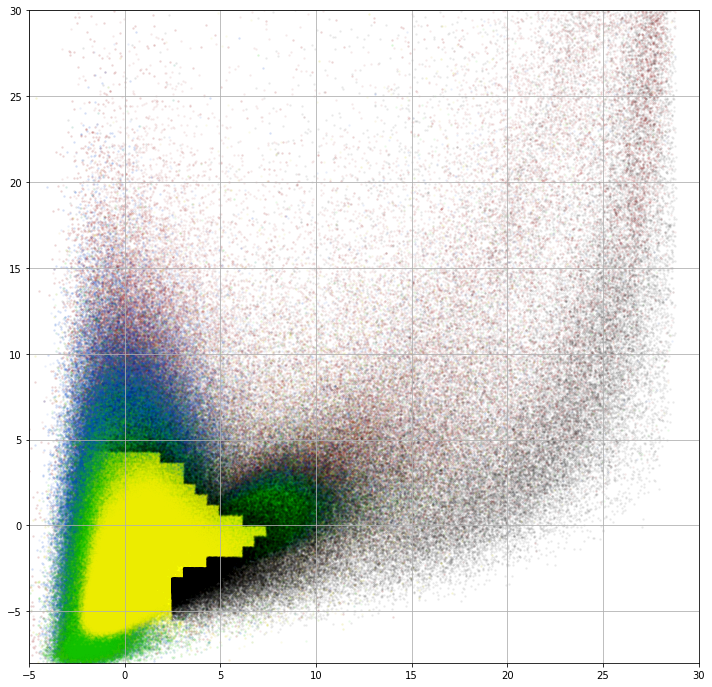

In [25]:
p = viz(SLB, 'FFT_dF_n', 'DTCWT_Entropy_n')
p.xlim(-5, 30)
p.ylim(-8, 30)

xs, ys = ('FFT_dF_n', 'DTCWT_Entropy_n')
G_, B_ = (GB[GB['matrix'] > threshold], GB[GB['matrix'] <= threshold]) 
p.scatter(G_[xs], G_[ys], alpha=0.05, s=2.5, color='#FF0')
p.scatter(B_[xs], B_[ys], alpha=0.05, s=2.5, color='#000')

plt.show()